Note: Training for just 40 epochs, won't be performing hyperparameter tuning, and or any metric calculation (perplexity or BLEU score) on the out-of-distribution datasets (val and test). 

Overall, the goal is to just to transform text data into a form that works with our neural networks and to train a simple Encoder-Decoder model for German to English translation.

# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import Counter # counter from python standard library
import spacy                    # tokenization step 

import torchtext
from torchtext.utils import download_from_url, extract_archive
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab

import io
import random

# needed the following to fix a bash execution error within Colab
import locale
locale.getpreferredencoding = lambda: "UTF-8"
# let's make sure we have a GPU available
print(torch.cuda.is_available())

True


In order to parse the sentence data we will be working with, we need to download the German and English dependencies from `spacy`. 

In [ ]:
!python -m spacy download en
!python -m spacy download de

# Download German / English Translation Dataset

In [ ]:
url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.de.gz', 'train.en.gz')
val_urls = ('val.de.gz', 'val.en.gz')
test_urls = ('test_2016_flickr.de.gz', 'test_2016_flickr.en.gz')

train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]

100%|██████████| 637k/637k [00:00<00:00, 82.0MB/s]
100%|██████████| 569k/569k [00:00<00:00, 68.9MB/s]
100%|██████████| 24.7k/24.7k [00:00<00:00, 4.99MB/s]
100%|██████████| 21.6k/21.6k [00:00<00:00, 8.49MB/s]
100%|██████████| 22.9k/22.9k [00:00<00:00, 6.93MB/s]
100%|██████████| 21.1k/21.1k [00:00<00:00, 9.39MB/s]


This downloads and extracts the text data within the `.data` directory.

In [ ]:
!ls .data

test_2016_flickr.de	test_2016_flickr.en.gz	train.en     val.de.gz
test_2016_flickr.de.gz	train.de		train.en.gz  val.en
test_2016_flickr.en	train.de.gz		val.de	     val.en.gz


Now, let's examine the first 10 sentences of both languages.

In [ ]:
lines_en = open(".data/train.en", 'r', encoding="utf-8").read().splitlines()
lines_de = open(".data/train.de", 'r', encoding="utf-8").read().splitlines()

NUM_LINES = 10
for i in range(NUM_LINES):
  print("German :", lines_de[i])
  print("English:", lines_en[i])
  print("-"*50)


German : Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
English: Two young, White males are outside near many bushes.
--------------------------------------------------
German : Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem.
English: Several men in hard hats are operating a giant pulley system.
--------------------------------------------------
German : Ein kleines Mädchen klettert in ein Spielhaus aus Holz.
English: A little girl climbing into a wooden playhouse.
--------------------------------------------------
German : Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster.
English: A man in a blue shirt is standing on a ladder cleaning a window.
--------------------------------------------------
German : Zwei Männer stehen am Herd und bereiten Essen zu.
English: Two men are at the stove preparing food.
--------------------------------------------------
German : Ein Mann in grün hält eine Gitarre, während der andere Mann sein 

Each setences is simply a Python string. So we need to convert this string into a tensor that works with our neural networks. The first step of this process is tokenization.

# Tokenizing our Data

In [ ]:
import io
import spacy
from collections import Counter
from  torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer

de_tokenizer = get_tokenizer('spacy', language='de_core_news_sm') 
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

The first step is to iterate through our corpus and count the occurences of each token. Let's use a `Counter` from the `collections` package which is part of the Python Standard Library (it's similar to a Python dictionary). Let's test out the `Counter` on the training dataset for the English sentences.

In [ ]:
counter = Counter()
with io.open('.data/train.en', encoding='utf8') as f:
  for string in f:
    counter.update(en_tokenizer(string))

Let's see the number of unique tokens we have:

In [ ]:
print(len(counter))

10834


Looks like we have 10834 unique words for our dataset. Now, let's print out the top 10 most frequent words in the Counter.

In [ ]:
sorted_counter = sorted(counter.items(), key=lambda kv: -kv[-1])
for i in range(10):
  print(sorted_counter[i])

('a', 31707)
('\n', 29000)
('.', 27623)
('A', 17458)
('in', 14847)
('the', 9923)
('on', 8019)
('is', 7524)
('and', 7378)
('man', 7359)


So, we can see the most frequent words found in our dataset. Note that the special character `\n` is the second most frequent! At this point, we can convert our `Counter` object into a vocab. Each key in our `Counter` dictionary is now a token. Our Torch vocabulary will map a token to an index in our vocab.

# Building a Vocab

In [ ]:
en_vocab = vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

Now, let's see how to use our `vocab` object. 

# stoi: Convert a token to an index in our vocab.

We can simply index into our `vocab` object with a token present in our training dataset. I'm guessing the word `cat` was in our training corpus:


In [ ]:
en_vocab["cat"]

1513

So, the token `cat` will always be mapped to the index `1513`.

# itos: Convet an index in our vocab to its token.

We can reverse this process as well using the `lookup_token()` function.

In [ ]:
en_vocab.lookup_token(1513)

'cat'

And so, we can seamlessly move between the token representation to the index representation. Here's another example for the exclamation punctuation mark:

In [ ]:
print(en_vocab['!'])

2391


In [ ]:
print(en_vocab.lookup_token(2391))

!


Now, let's check out the index in our vocab for the special tokens we passed to our `vocab` object from before:

In [ ]:
print(en_vocab['<unk>'])
print(en_vocab['<pad>'])
print(en_vocab['<bos>'])
print(en_vocab['<eos>'])

0
1
2
3


In [ ]:
en_vocab.set_default_index(en_vocab["<unk>"])

Now, let's see what index we get for a couple of misspelled words:

In [ ]:
print(en_vocab['fjflsj']) # some random string
print(en_vocab['appel']) # apple misspelled

0
0


They both get mapped to the unknown token! Let's wrap this all up in a function and build our vocab for both German and English.

In [ ]:
def build_vocab(filepath, tokenizer):
  counter = Counter()
  with io.open(filepath, encoding="utf8") as f:
    for string_ in f:
      counter.update(tokenizer(string_))
  return vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

de_vocab = build_vocab('.data/train.de', de_tokenizer)
de_vocab.set_default_index(de_vocab['<unk>'])
en_vocab = build_vocab('.data/train.en', en_tokenizer)
en_vocab.set_default_index(en_vocab['<unk>'])

Let's check the size of our vocab for both languages.

In [ ]:
len(de_vocab), len(en_vocab)

(19215, 10838)

# Convert Sentences to Torch Tensors

At this stage, we can now map tokens to indices which are integers. We are one step closer to being able to pass text data into our neural networks. The following function just maps each token in each sentecne to their respective index for both vocabs.

In [ ]:
def data_process(filepaths):
  raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
  raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
  data = []
  for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
    de_tensor_ = torch.tensor([de_vocab[token] for token in de_tokenizer(raw_de)],
                            dtype=torch.long)
    en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en)],
                            dtype=torch.long)
    data.append((de_tensor_, en_tensor_))
  return data

train_data = data_process(train_filepaths)
val_data = data_process(val_filepaths)
test_data = data_process(test_filepaths)

In [ ]:
train_data[0]

(tensor([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]),
 tensor([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]))

As a sanity check, let's convert each index in the first example sentence back to its token:

In [ ]:
de_sentence, en_sentence = train_data[0] # get the first training example
for idx in de_sentence:
  print(de_vocab.lookup_token(idx), end=' ')

for idx in en_sentence:
  print(en_vocab.lookup_token(idx), end=' ')

Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche . 
 Two young , White males are outside near many bushes . 
 

Now, we are ready to create our DataLoaders.

# DataLoader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128
PAD_IDX = de_vocab['<pad>']
BOS_IDX = de_vocab['<bos>']
EOS_IDX = de_vocab['<eos>']

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def generate_batch(data_batch):
  de_batch, en_batch = [], []
  for (de_item, en_item) in data_batch:
    de_batch.append(torch.cat([torch.tensor([BOS_IDX]), de_item, torch.tensor([EOS_IDX])], dim=0)) #BOS Sentence EOS - German
    en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0)) #BOS Sentence EOS - English
  de_batch = pad_sequence(de_batch, padding_value=PAD_IDX)
  en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
  return de_batch, en_batch

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)


# Explore Torchified Sentence Data

Let's explore the data that's returned by our Dataloader. This data will be input to our Encoder-Decoder Neural Machine Translation Model:

In [ ]:
src_de, trg_en = next(iter(train_iter))
print(src_de.shape, trg_en.shape)

torch.Size([31, 128]) torch.Size([33, 128])


The size of our torch objects are: `length of sentence` $\times$ `batch size`

We set the batch size to 128 and each sentence in a batch will have the same length. Note that the sentence size might `differ` between the languages. Let's print out our first German sentence:

In [ ]:
print(src_de[:, 0])

tensor([   2,   24, 1072, 1674, 2843,  732,   11,   68, 2587,   52,   53,   12,
        2884, 1521,  961, 1277,   47, 5235,  282,   16,   17,    3,    1,    1,
           1,    1,    1,    1,    1,    1,    1])


Let's print the values of our special tokens again:

In [ ]:
print(en_vocab['<bos>'])
print(en_vocab['<eos>'])
print(en_vocab['<pad>'])

2
3
1


So, we can see our sentence starts with the `<bos>` token, ends with several `<pad>` tokens. The actual sentences itself ends with the `<eos`> token.

Let's convert this German sentence to their tokens:

In [ ]:
for word in src_de[:,0]:
  print(de_vocab.lookup_token(word), end=' ')

<bos> Ein weiß gekleideter Baseballspieler rutscht in die Base , während der grau gekleidete Spieler ihn zu berühren versucht . 
 <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

Since there is a one to one mapping between the German and English sentences, let's go ahead and print the first English sentence as well. It should be the corresponding English sentence.

In [ ]:
for word in trg_en[:,0]:
  print(en_vocab.lookup_token(word), end=' ')

<bos> A baseball player in white is sliding into the base while the player in gray is trying to tag him . 
 <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

Finally, let's print the first 10 German sentences. Each sentence will be a column that starts with the index 2 (`<bos>` token) and is padded to be the same length. Confirm that each sentence has the `<eos>` token.

In [ ]:
print(src_de[:,:10])

tensor([[    2,     2,     2,     2,     2,     2,     2,     2,     2,     2],
        [   24,    71,   408,    24,    71,    24,    24,    24,    24,    24],
        [ 1072,    72, 14316,   251,    72,  2843,   251,  5434,    31,    97],
        [ 1674,    19,    36,    19,    11,   463,    11,  1192,   116,    98],
        [ 2843,   984,    37,  1006,    32,    22,    32,   213,   489,    19],
        [  732,   274,  1759,  3961,   278, 18241,  5252,   852,    11,    37],
        [   11,    58,    47,    22,    34,   827,    36,  2398,    12,  6561],
        [   68,   490,  2544,   283,    49,  3505,    32,  2241, 11398,    35],
        [ 2587,  1400,    16,  3385,    58,    52,  5929,    68,    52,   117],
        [   52,    52,    17,    36,  7355,   233,    33,   280,    36,    22],
        [   53,    61,     3,    22,   320,    47,  1255,   681,    32,   391],
        [   12,    64,     1, 17631,    16,    37,     9,    52,  2853,   295],
        [ 2884, 14690,     1,    16,    

# Setting up our Neural Machine Translation Model

We are ready to setup our Neural Machine Translation model. We will be using an Encoder-Decoder model where both the components will be RNNs (in particular, [GRUs](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)). Remember, we are working with sequence data so each token will be input sequentially to our GRU units. Recall also that the weights of our GRU units will be reused for each token. At a high level: our model looks like this:

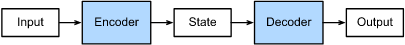

In [ ]:
embedding = nn.Embedding(10, 4)
print(embedding)
print(embedding.weight.data)

Embedding(10, 4)
tensor([[-0.3741,  0.6554, -1.7362,  0.0513],
        [ 1.5785,  1.5529,  0.9754,  0.3551],
        [-1.9181,  1.2132, -0.4472,  0.6887],
        [ 0.1751, -0.4901,  0.1189,  0.6863],
        [-0.7948, -2.2631, -3.5633,  1.3887],
        [-0.9918, -0.6075, -0.0085, -0.5732],
        [-0.1582, -0.4766, -0.7730, -0.3657],
        [ 0.2304,  0.4892,  0.0140,  0.4349],
        [ 0.0244, -1.2378, -0.6552,  0.9723],
        [-1.3659,  1.7206, -1.0083,  0.5567]])


Notice that the embedding is simply a $10 \times 4$ weight matrix. Each token will index into our embedding and return a row of this matrix.

Suppose we want to transform the `<bos>` token (which has an index of 2 in our both of our vocabs). We can do perform the embedding as follows:

In [ ]:
print(embedding(torch.tensor([[en_vocab['<bos>']]]))) ## equivalent to embedding(torch.tensor([[2]]))

tensor([[[-1.9181,  1.2132, -0.4472,  0.6887]]], grad_fn=<EmbeddingBackward0>)


This is just the third row in our embedding matrix. Note the associated `grad_fn` with the embedding table. This means we can train embeddings! Through the training process, similar words can be hopefully be transformed to similar embeddings.

## Setting up the Model
Now, we are ready to build our encoder-decoder model. We need to first embed our indices to our representation space and process them through the GRUs. We will be use a bidirectional GRU for the encoder in order to process the source German sentence in both directions ([Sutskever et al. 2014](https://arxiv.org/abs/1409.3215) found this helpful). Doing so increases the depth of the encoder GRU by a factor of two.

We will use:

- an embedding space of size 128
- a hidden state size of 256
- 4-layer GRUs

In [ ]:
class Seq2Seq(nn.Module):
  def __init__(self):
    super(Seq2Seq, self).__init__()
    SRC_EMB_SIZE = 128
    TRG_EMB_SIZE = 128
    H_SIZE = 256
    LAYERS = 4

    self.src_emb = nn.Embedding(len(de_vocab), 128) # embedding for german tokens
    self.trg_emb = nn.Embedding(len(en_vocab), 128) # embedding for english tokens

    self.encoder = nn.GRU(SRC_EMB_SIZE, H_SIZE, LAYERS//2, bidirectional=True) # bidirectional encoder
    self.decoder = nn.GRU(TRG_EMB_SIZE, H_SIZE, LAYERS) # decoder
    self.to_trg = nn.Linear(H_SIZE, len(en_vocab)) # transform the hidden states to a probability distribution

  def forward(self, src_ids, trg_ids):
    src_emb = self.src_emb(src_ids) # embed the german tokens
    enc_output, enc_hidden = self.encoder(src_emb) # process through the bidirectional GRU


    trg_emb = self.trg_emb(trg_ids) # embed the english tokens (just for training)
    dec_output, dec_hidden = self.decoder(trg_emb, enc_hidden) # process target through decoder GRU, note the hidden state 

    logits = self.to_trg(dec_output) # convert each hidden state to a distribution over the english language
    preds = F.log_softmax(logits, dim=2) # convert to a normalized dist.
    return preds

Let's perform a sanity check and make sure things work:

In [ ]:
model = Seq2Seq()
src_de, trg_en = next(iter(train_iter))
print(src_de.shape, trg_en.shape)
model.eval()
with torch.no_grad():
  out = model(src_de, trg_en)

torch.Size([32, 128]) torch.Size([31, 128])


Let's analyze the output shape of our network:

In [ ]:
out.shape

torch.Size([31, 128, 10838])

We see `torch.Size([31, 128, 10838])`:

- 31 is the output size of our English sentences
- 128 is the batch size
- each of the 31 output hidden states maps to a distribution over the English langauge (which had a size of 10838 tokens)

# Model Training

Let's train this model. We will use the Adam optimizer. Importantly, we don't want the `<pad>` token to contribute to our loss since it's just for training purposes, so let's handle that.

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())
PAD_IDX = en_vocab['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

Note that we will be using teacher forcing as described previously. For the input to the decoder, we chop off the final token (`trg[:-1]`). For the loss function, we chop off the first token of the target sentence (`trg[1:]`) to obtain our ground truth tokens. Recall that RNN models are prone to both gradient vanishing and exploding. Let's clip the gradients if they are too large.

In [ ]:
model = model.cuda()
model.train()
for epoch in range(40):
  epoch_loss = 0
  for _, (src, trg) in enumerate(train_iter):
    src, trg = src.cuda(), trg.cuda()
    optimizer.zero_grad()

    #teacher-forcing
    output = model(src, trg[:-1]) # removing the last token
    output = output.view(-1, output.shape[-1])

    loss = criterion(output, trg[1:].view(-1)) # removing the first token

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1) # grad clipping

    optimizer.step() # update our weights

    epoch_loss += loss.item()
  print(f"Epoch {epoch}:", epoch_loss / len(train_iter))


Epoch 0: 4.926530113304239
Epoch 1: 4.003010595422484
Epoch 2: 3.384852639378955
Epoch 3: 3.013778653964072
Epoch 4: 2.7345615998238717
Epoch 5: 2.5076538938782815
Epoch 6: 2.3079120944775147
Epoch 7: 2.127656368957217
Epoch 8: 1.9613322502715997
Epoch 9: 1.8055939700634993
Epoch 10: 1.6560819637407815
Epoch 11: 1.5185737315778691
Epoch 12: 1.388288369262796
Epoch 13: 1.2640819502296952
Epoch 14: 1.1521452927904507
Epoch 15: 1.0449961833491725
Epoch 16: 0.9463206175140347
Epoch 17: 0.8578489257375574
Epoch 18: 0.7723013556476207
Epoch 19: 0.6927754246190782
Epoch 20: 0.6184131293044741
Epoch 21: 0.5528884221541199
Epoch 22: 0.4944252854926996
Epoch 23: 0.4407538074491308
Epoch 24: 0.39049183705304685
Epoch 25: 0.3448183296272933
Epoch 26: 0.30316996797591056
Epoch 27: 0.2650890880087924
Epoch 28: 0.23480227569914075
Epoch 29: 0.2096506143850377
Epoch 30: 0.18725315563479183
Epoch 31: 0.17502348755162192
Epoch 32: 0.16177015991200436
Epoch 33: 0.14989684728930175
Epoch 34: 0.13830567650

# Model Prediction

At this point, we are ready to take a never-before-seen German sentence and translate it. We will write a fucntion below that performs the prediction as we noted above:

In [ ]:
def greedy_sample(src, trg, idx):
##########################################################################
  # push batch to the GPU
  src, trg = src.cuda(), trg.cuda()
  model.eval()

  # pull one sentence out using the idx parameter
  sample = src[:, idx:idx+1] # choosing a sentence in German
  gt = trg[:, idx:idx+1]     # correct English translation from the dataset
    
  # convert indices to tokens
  input = [de_vocab.lookup_token(sample[i,0]) for i in range(len(sample))]
  input = input[1:input.index("<eos>")]
  gt = [en_vocab.lookup_token(gt[i, 0]) for i in range(len(gt))]
  gt = gt[1:gt.index("<eos>")]
  # print both the input german sentence and the ground truth
  print("input:", " ".join(input))
  print("gt   :", " ".join(gt))



##########################################################################
  # perform model prediction (inference)
  output = []
  # embed source sentence
  src_sen_emb = model.src_emb(sample)
  # process through the encoder
  enc_output, enc_hidden = model.encoder(src_sen_emb)
  dec_hidden = enc_hidden # set the first hidden state of the decoder to the final hidden state of encoder

  # start our sentence with the beginning of sequence token
  out = de_vocab['<bos>']

  # sample for 40 tokens
  for i in range(40):
    
    # embed the current token (starts at <bos>)
    trg_sen_emb = model.trg_emb(torch.tensor([[out]], device='cuda'))
    dec_output, dec_hidden = model.decoder(trg_sen_emb, dec_hidden) #note the hidden state, starts as enc_hidden
    preds = F.log_softmax(model.to_trg(dec_output), dim=2) # produce probabilities for each decoder hidden state
    out = preds.argmax(2) # choosing the word with the highest probability
    output.append(en_vocab.lookup_token(out.item())) # convert to token
    
  # print our prediction
  if "<eos>" in output:
    output = output[:output.index("<eos>")]
  print("pred:", " ".join(output))

Let's try out our trained Neural Machine Translation Model.

In [ ]:
src, trg = next(iter(test_iter))
print(src.shape, trg.shape)

torch.Size([34, 128]) torch.Size([36, 128])


In [ ]:
rnd_idx = random.randint(0,128)
greedy_sample(src, trg, rnd_idx)

input: Zwei Männer in Anzügen unter einem Regenschirm vor einem Graffiti . 

gt   : Two men in suits under an umbrella and in front of graffiti . 

pred: Two men in military clothing are outside in a front of truck . 



So, we can see it's performing *some* translation, but maybe not the best. Let's try a few more samples:

In [ ]:
rnd_idx = random.randint(0,128)
greedy_sample(src, trg, rnd_idx)

input: Ein junges Paar sitzt auf dem Gehsteig und entspannt gemeinsam . 

gt   : A young couple sits on the sidewalk and relaxes together . 

pred: A young couple is sitting on the sidewalk wearing camping or clothing . 



Note the unknown tokens in the next example. This means that the token didn't appear in our German training dataset. Thankfully, our default `<unk>` token handles this gracefully for us. 

In [ ]:
rnd_idx = random.randint(0,128)
greedy_sample(src, trg, rnd_idx)

input: Leute gehen auf einer befestigten <unk> Straße , umgeben von <unk> Händlern . 

gt   : People are walking on a paved slope surrounded by Chinese vendors . 

pred: People walk down a busy crowded street with many stone lights . 



In [ ]:
rnd_idx = random.randint(0,128)
greedy_sample(src, trg, rnd_idx)

input: Ein Mann in einem weißen Hemd blickt durch ein Fenster einer Metallkonstruktion . 

gt   : A man wearing a white shirt is looking out a window of a metal construction . 

pred: A man in a white shirt looks at a window through a marketplace . 

